# 05. 結構化流行病模組 (SEIR + ML Calibration)

**目的**：結合傳染病動力學 (Compartmental Models) 與數據驅動的參數估計。
**為什麼需要 SEIR？**：
*   機器學習 (XGBoost/LSTM) 擅長捕捉相關性，但缺乏機制解釋 (Why)。
*   SEIR 模型具有明確的流行病學參數 (Beta: 傳染率, Gamma: 康復率)，可以直接進行「反事實模擬」(例如：如果 Beta 增加 20% 會怎樣？)。

**內容**：
1.  **SEIR 模型定義**：使用 `scipy.integrate.odeint` 解微分方程。
2.  **參數校準 (Calibration)**：使用 `scipy.optimize` 或簡單網格搜索找出最符合真實數據的 $R_0$ (或 Beta)。
3.  **反事實模擬 (Counterfactuals)**：固定模型結構，調整參數以模擬「平行世界」的疫情發展。

In [16]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 定義路徑
raw_data_dir = "../data/raw"
processed_data_dir = "../data/processed"
file_case = os.path.join(processed_data_dir, "twcdc_daily_cases_by_location.csv") # 修正讀取處理後的資料

## 1. 資料載入與預處理
載入已聚合的每日全台病例數。

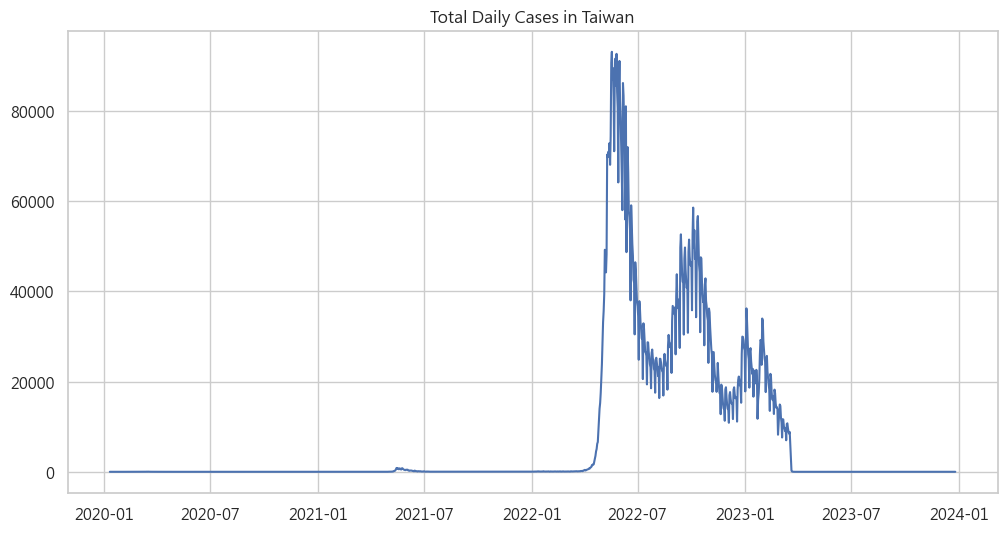

Fitting Period: 2021-05-01 to 2021-08-31, Days: 123


In [17]:
try:
    # 讀取處理後的資料 (Location 為欄位)
    df = pd.read_csv(file_case, index_col='Date', parse_dates=True)
    
    # 聚合為全台總數 (Total Cases)
    total_cases = df.sum(axis=1)
    
    # 轉換為累積病例數 (Cumulative Cases) - SEIR 擬合通常使用累積數或當下感染數
    # 這裡我們用「目前感染者 (Infected)」的概念比較複雜(需要扣除康復)，
    # 簡化起見，我們先擬合「每日新增 (Daily New)」或「累積確診」。
    # 為了 ODE 求解穩定，我們通常擬合 Cumulative Cases。
    cumulative_cases = total_cases.cumsum()
    
    # 建立建模用 DataFrame
    model_data = pd.DataFrame({
        'Date': total_cases.index,
        'Daily': total_cases.values,
        'Cumulative': cumulative_cases.values,
        'Days': np.arange(len(total_cases))
    })
    
    # 選擇一段「爆發期」進行擬合 (例如 2021-05 ~ 2021-08)
    # 這裡先視覺化選定區間
    plt.figure(figsize=(12, 6))
    plt.plot(model_data['Date'], model_data['Daily'], label='Daily Cases')
    plt.title('Total Daily Cases in Taiwan')
    plt.show()
    
    # 假設我們專注於主要波段 (Masking: 這裡簡單選取 > 10 例的日子)
    # 實際操作可由使用者指定 start_date / end_date
    start_date = '2021-05-01'
    end_date = '2021-08-31'
    
    mask = (model_data['Date'] >= start_date) & (model_data['Date'] <= end_date)
    fit_data = model_data.loc[mask].reset_index(drop=True)
    fit_data['Days'] = np.arange(len(fit_data)) # Reset days for ODE
    
    print(f"Fitting Period: {start_date} to {end_date}, Days: {len(fit_data)}")
    
except FileNotFoundError:
    print("Processed data file not found.")
    # Mock data for structure testing if file missing
    fit_data = pd.DataFrame({'Days': np.arange(100), 'Cumulative': np.linspace(0, 1000, 100)})

## 2. 定義 SEIR 模型 (ODE System)

方程組：
*   $dS/dt = -\beta * S * I / N$
*   $dE/dt = \beta * S * I / N - \sigma * E$
*   $dI/dt = \sigma * E - \gamma * I$
*   $dR/dt = \gamma * I$

參數：
*   $N$: 總人口 (台灣約 23,500,000)
*   $\beta$: 傳染率 (Contact Rate * Transmission Probability)
*   $\sigma$: 潛伏率 (1 / Incubation Period, 約 1/5.2 天)
*   $\gamma$: 康復/移除率 (1 / Infectious Period, 約 1/10 天)

In [18]:
def seir_model(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

# 固定參數 (參考文獻)
N = 23500000
sigma = 1.0 / 5.2  # 潛伏期 ~5.2天
gamma = 1.0 / 10.0 # 傳染期 ~10天

## 3. 參數估計 (Calibration)
我們將優化 $\beta$ (Beta) 與初始感染人數 $I_0$ 以擬合真實的累積確診數。

In [19]:
def fit_seir(params, data):
    beta, I0 = params
    
    # Initial conditions
    E0 = I0 # Assume exposed ~ infected initially
    R0_init = 0 # Recovered initially 0 (for this wave)
    S0 = N - E0 - I0 - R0_init
    y0 = S0, E0, I0, R0_init
    
    # Solve ODE
    t = data['Days'].values
    ret = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = ret.T
    
    # Cumulative Cases = N - S (approx, ignoring E/I dynamic shifts for simple fitting)
    # 或者更準確：Cumulative Cases(t) = Integral(sigma*E) dt
    # 這裡簡單用 R + I 來近似「已確診+具傳染力」，或 R 作為「累積確診(假設確診即隔離/康復)」
    # 最常用擬合目標是 Cumulative Confirmed -> 近似為 R (如果 I 轉入 R 視為確診)
    # 但 SEIR 的 R 是 Recovered。在台灣數據中，Confirmed 通常是累積的。
    # 我們用 (N - S) 作為「累積總感染數」來擬合「累積確診數」。
    # 注意：這假設所有感染都被確診 (Undercounting rate = 0)
    
    pred_cumulative = N - S
    
    # Loss function: MSE (Mean Squared Error)
    # Scale down large numbers to avoid overflow
    loss = np.mean((pred_cumulative - data['Cumulative'].values)**2)
    return loss

# 初始猜測 [beta, I0]
initial_guess = [0.2, 100]
bounds = [(0.0, 1.0), (1, 10000)] # beta > 0, I0 > 1

if 'fit_data' in locals() and not fit_data.empty:
    # 為了讓優化器運作順利，我們只擬合 Cumulative 的增量 (offset start)
    # 或者將 fit_data['Cumulative'] 減去起始值
    fit_data_shifted = fit_data.copy()
    start_cases = fit_data['Cumulative'].iloc[0]
    fit_data_shifted['Cumulative'] = fit_data['Cumulative'] - start_cases
    
    # Run Optimization
    res = minimize(fit_seir, initial_guess, args=(fit_data_shifted,), bounds=bounds, method='L-BFGS-B')
    
    beta_opt, I0_opt = res.x
    R0_reproduction = beta_opt / gamma
    
    print(f"Optimal Beta: {beta_opt:.4f}")
    print(f"Optimal I0: {I0_opt:.2f}")
    print(f"Basic Reproduction Number (R0): {R0_reproduction:.2f}")

Optimal Beta: 0.0942
Optimal I0: 1572.28
Basic Reproduction Number (R0): 0.94


## 4. 視覺化擬合結果與反事實模擬 (Counterfactuals)

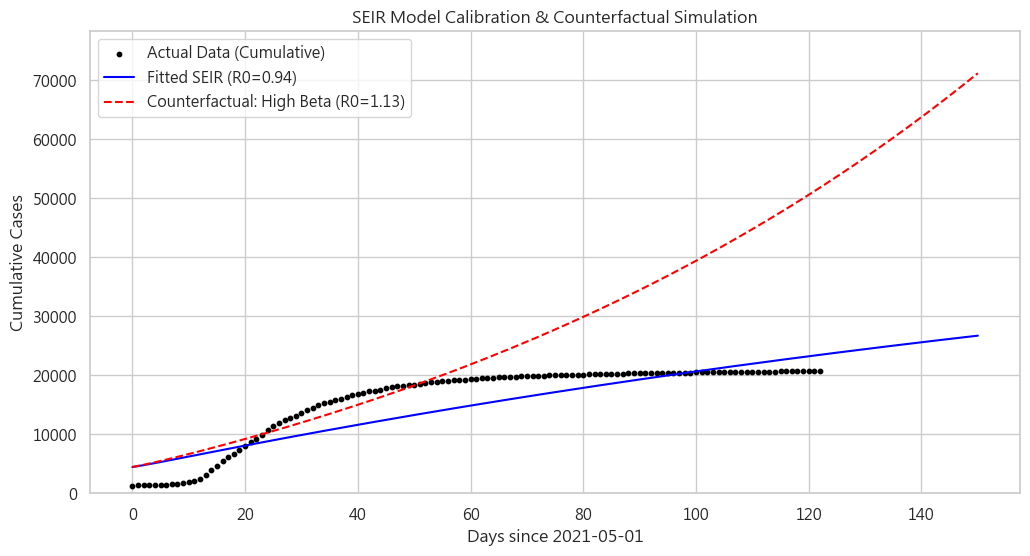

In [20]:
if 'beta_opt' in locals():
    # 1. 產生擬合曲線
    t_sim = np.linspace(0, 150, 150) # Extend simulation to see future trend
    
    # Fitted Scenario
    y0_fit = (N - I0_opt*2, I0_opt, I0_opt, 0)
    ret_fit = odeint(seir_model, y0_fit, t_sim, args=(N, beta_opt, sigma, gamma))
    S_fit, E_fit, I_fit, R_fit = ret_fit.T
    cum_fit = N - S_fit + start_cases # Add back offset
    
    # 2. Counterfactual Scenario: High Transmission (e.g., No NPIs, Beta + 20%)
    beta_cf = beta_opt * 1.2
    ret_cf = odeint(seir_model, y0_fit, t_sim, args=(N, beta_cf, sigma, gamma))
    S_cf, E_cf, I_cf, R_cf = ret_cf.T
    cum_cf = N - S_cf + start_cases

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Real Data
    plt.scatter(fit_data['Days'], fit_data['Cumulative'], label='Actual Data (Cumulative)', color='black', s=10)
    
    # Fitted Model
    plt.plot(t_sim, cum_fit, label=f'Fitted SEIR (R0={beta_opt/gamma:.2f})', color='blue')
    
    # Counterfactual Model
    plt.plot(t_sim, cum_cf, label=f'Counterfactual: High Beta (R0={beta_cf/gamma:.2f})', color='red', linestyle='--')
    
    plt.title('SEIR Model Calibration & Counterfactual Simulation')
    plt.xlabel('Days since ' + start_date)
    plt.ylabel('Cumulative Cases')
    plt.legend()
    plt.ylim(0, max(cum_cf.max(), fit_data['Cumulative'].max()) * 1.1)
    plt.show()